## Quiver Animation

This notebook demonstrates how to create animated visualizations of wind and temperature data from climate projections. We'll use IFS-NEMO high-resolution data from the ScenarioMIP SSP3-7.0 scenario.

### Dataset Information

Source: ScenarioMIP SSP3-7.0 IFS-NEMO high-resolution surface data
Variables:

- t2m: 2-meter temperature (Kelvin)
- u10: 10-meter zonal wind component (m/s)
- v10: 10-meter meridional wind component (m/s)

Region: European domain (35°N-71°N, 10°W-40°E)


In [5]:
import numpy as np
import random
import tqdm
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.collections import LineCollection
from IPython.display import HTML
from loguru import logger
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pathlib import Path

## Earth Data Hub Auth

In [1]:
%%capture cap
%run auth/cacheb-authentication.py

In [4]:
output_1 = cap.stdout.split('}\n')
token = output_1[-1][0:-1]

with open(Path.home() / ".netrc", "a") as fp:
    fp.write(token)

## Get Data

In [6]:
url = "https://cacheb.dcms.destine.eu/d1-climate-dt/ScenarioMIP-SSP3-7.0-IFS-NEMO-0001-high-sfc-v0.zarr"

latitude_range = [35.0, 71.0]
longitude_range = [-10.0, 40.0]
start_date = "2023-03-05"
end_date = "2023-03-05"
data = xr.open_dataset(url, engine="zarr",
                          storage_options={"client_kwargs": {"trust_env": "true"}},
                          chunks={})

data = data.sel(latitude=slice(latitude_range[0],latitude_range[1]),
                longitude=slice(longitude_range[0],longitude_range[1]),
                time=slice(start_date, end_date))

data = data[["t2m", "u10", "v10"]].load()

Extract parameters for a given time

In [7]:
timestep = 10
# Extract wind components at the given timestep
u10 = data['u10'].isel(time=timestep)
v10 = data['v10'].isel(time=timestep)
t2m = data['t2m'].isel(time=timestep)
lon = data['longitude']
lat = data['latitude']
# Calculate wind speed
wind_speed = np.sqrt(u10**2 + v10**2)

Subsample for visualization

In [8]:
step = 2
lon_sub = lon[::step]
lat_sub = lat[::step]
u10_sub = u10[::step, ::step]
v10_sub = v10[::step, ::step]
wind_speed_sub = wind_speed[::step, ::step]

## Basic Visualization

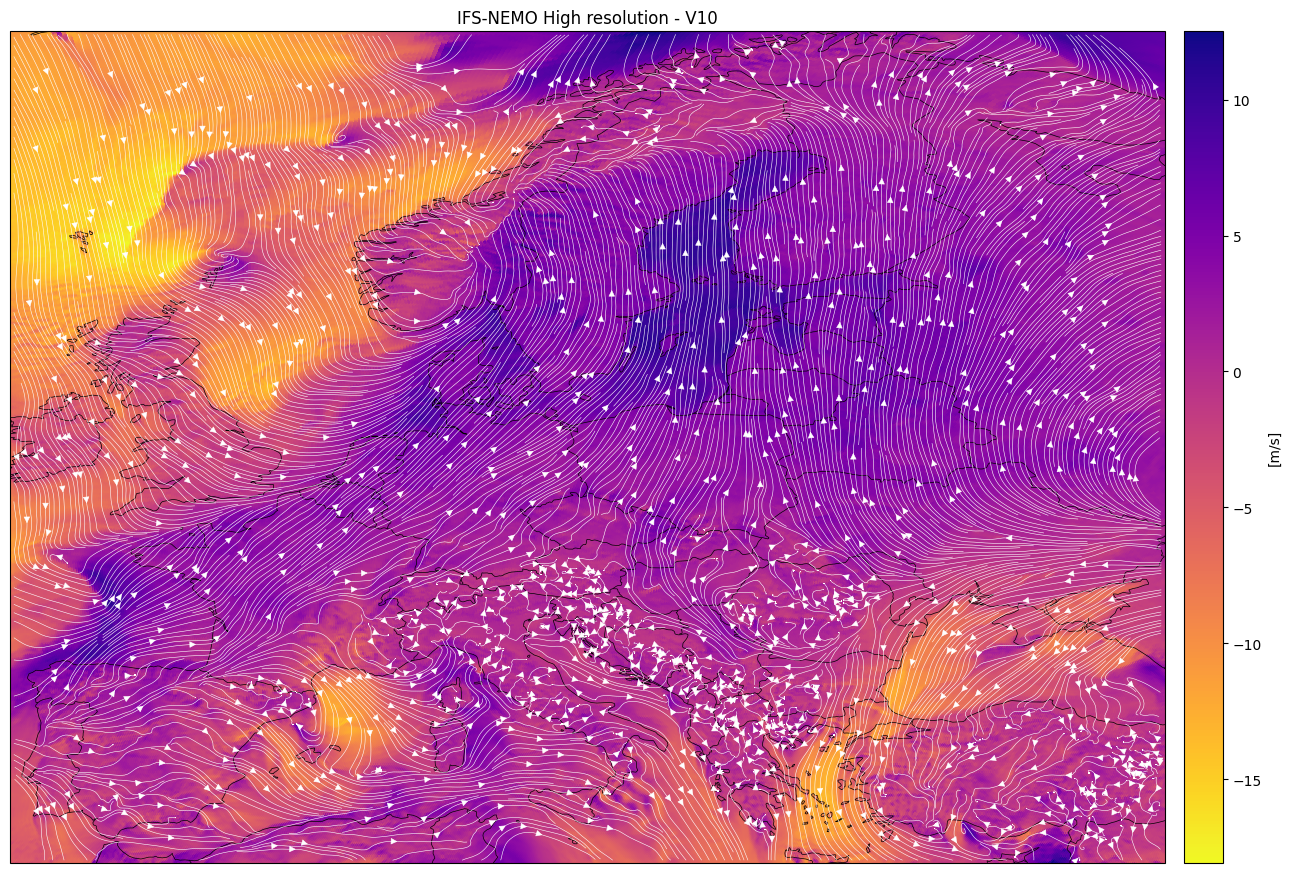

In [9]:
fig, ax = plt.subplots(figsize=(19.2, 10.8), dpi=100, subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
heatmap = ax.pcolormesh(data['longitude'], data['latitude'], v10, cmap="plasma_r", transform=ccrs.PlateCarree())
# Initialize the streamplot
stream = ax.streamplot(lon_sub, lat_sub, u10_sub, v10_sub, color="white", density=10, linewidth=0.4)
# Get the segments of the streamlines
segments = stream.lines.get_segments()
pos = ax.get_position()
plt.title('IFS-NEMO High resolution - V10')
cbar_ax = fig.add_axes([pos.x1 + 0.01, pos.y0, 0.02, pos.height])
cbar = fig.colorbar(heatmap, cax=cbar_ax, orientation='vertical')
cbar.set_label("[m/s]")
plt.show()

In [10]:
fig, ax = plt.subplots(figsize=(19.2, 10.8), dpi=100, subplot_kw={'projection': ccrs.PlateCarree()})
heatmap = ax.pcolormesh(data['longitude'], data['latitude'], t2m,
                        cmap="plasma_r", transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
pos = ax.get_position()
cbar_ax = fig.add_axes([pos.x1 + 0.01, pos.y0, 0.02, pos.height])
cbar = fig.colorbar(heatmap, cax=cbar_ax, orientation='vertical')
cbar.set_label("[K]")
ax.set_title('IFS-NEMO High resolution - t2m - Temperature [K]')

lengths = []
colors = []
lines = []

segments = stream.lines.get_segments()

for streamline in segments:

    s = streamline.T
    x, y = s[0], s[1]

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    seg = np.concatenate([points[:-1], points[1:]], axis=1)
    n = len(seg)
    # Compute cumulative length along streamline
    D = np.sqrt(((points[1:] - points[:-1])**2).sum(axis=-1))
    L = D.cumsum().reshape(n, 1) + np.random.uniform(0, 1)

    # Create white color with gradient transparency
    C = np.ones((n, 4))  # (R=1, G=1, B=1, Alpha)
    C[:, 3] = np.linspace(0.0, 1.0, n)
    C[::-1] = (L*1.5) % 1

    # Apply colors and transparency to LineCollection
    line = LineCollection(seg, colors=C, linewidth=0.4, transform=ccrs.PlateCarree())
    lengths.append(L)
    colors.append(C)
    lines.append(line)
    ax.add_collection(line)

def update(frame_no):
    for i in range(len(lines)):
        # Adjust movement based on random wind speed (scaled appropriately)
        lengths[i] -= random.uniform(0.1, 1.2)
        # Adjust transparency dynamically
        colors[i][::-1] = (lengths[i] * 0.1) % 1
        # Update streamline color
        lines[i].set_color(colors[i][::-1])
    pbar.update()

n = 100
animation = FuncAnimation(fig, update, frames=n, interval=8)
pbar = tqdm.tqdm(total=n)
animation.save('ifs_nemo_europe_t2m_wind.mp4', writer='ffmpeg', fps=8)
pbar.close()
plt.close()

  4%|▍         | 4/100 [00:09<04:22,  2.73s/it]

101it [08:12,  4.88s/it]                         


End of the Notebook 🚀